# Forward Simulation of 2D VEP model at Sensor level

In [1]:
import os
import sys
import time
import errno
import time
import timeit


import numpy as np
import numba
from numba import jit

import matplotlib.pyplot as plt
from matplotlib import colors, cm

In [2]:
import warnings
warnings.simplefilter("ignore")

In [3]:
%pylab inline
#%matplotlib notebook

Populating the interactive namespace from numpy and matplotlib


In [4]:
cwd = os.getcwd()
cwd

'/data/VEP_benchmark/VEP_Optimization_Benchmark'

In [5]:
Res_dir='data_output_files'

In [6]:
I1=3.1
eta_c=-2.05        
delta_eta=1.0                  
prior_std =1.0
sd_thr=0.8

## Structural Connectivity and Gain Matrices

In [7]:
weights = np.loadtxt(os.path.join(cwd+"/ExperimentalData/connectivity", "weights.txt"))

In [8]:
# normalize Connectome
weights = weights/np.max(weights)
num_regions = len(weights)

In [9]:
weights.min(), weights.max()

(0.0, 1.0)

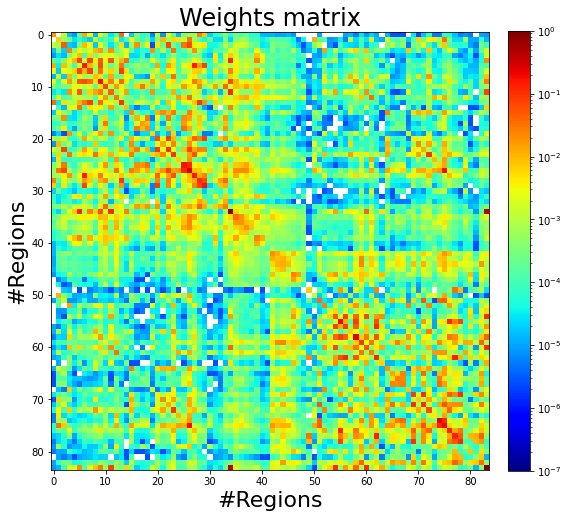

In [10]:
plt.figure(figsize=(8, 8))

norm = colors.LogNorm(1e-7, weights.max())
im = plt.imshow(weights,norm=norm,cmap=cm.jet)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().set_title('Weights matrix', fontsize=24.0)
plt.ylabel('#Regions', fontsize=22.0)
plt.xlabel('#Regions', fontsize=22.0)
plt.tight_layout()
plt.show()

## ROIs chosen as Epileptogenic/propagation zones

In [11]:
# here we set the ground-truth

hz_val=-3.5 
pz_val=-2.4
ez_val=-1.6

ez_idx = np.array([6, 34],  dtype=np.int32)
pz_idx = np.array([5, 11, 27],  dtype=np.int32)

In [12]:
nn=84

In [13]:
hz_idx=np.array(list(set(np.r_[0:nn])-set(ez_idx)-set(pz_idx)))

In [14]:
#Here, we increase manually the weights between EZ and PZ to get propagation:
weights[np.ix_(np.array([5,11]), ez_idx)] = 4.0
weights[np.ix_(np.array([27]), ez_idx)] = 1.0

In [15]:
# SC is given to simulator as fixed values (at the end we use this matrix to connect the nodes.) 
SC=weights
SC.shape

(84, 84)

In [16]:
Gain = np.loadtxt(os.path.join(cwd+"/ExperimentalData", "gain_inv-square.txt"))

In [17]:
Gain.shape

(162, 84)

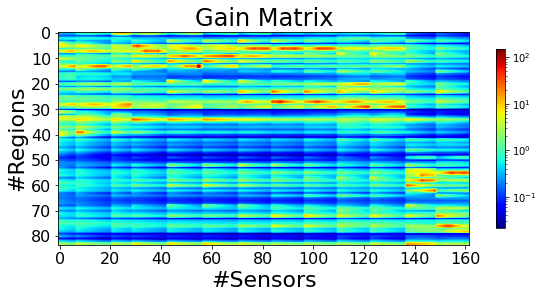

In [18]:
plt.figure(figsize=(8, 4))
norm = colors.LogNorm(Gain.min(), Gain.max())
im = plt.imshow(Gain.transpose(),norm=norm,cmap=cm.jet)
plt.colorbar(im, fraction=0.02, pad=0.06)
plt.gca().set_title('Gain Matrix', fontsize=24.0)
plt.xticks(fontsize=16, rotation=0)
plt.yticks(fontsize=16, rotation=0)
plt.ylabel('#Regions', fontsize=22.0)
plt.xlabel('#Sensors', fontsize=22.0)
plt.show()

### Simulator

In [19]:
@jit(nopython=False) 
def VEP2Dmodel_sensor(params, constants, init_conditions, SC, Gain, dt, ts):
    
    nt=ts.shape[0]
    nn=SC.shape[0]
    ns=Gain.shape[0]

    #parameters
    eta=params[0:nn]
    K=params[-1]
    
    # fixed parameters
    tau0, I1, sigma=constants[0], constants[1], constants[2]


    # simulation from initial point
    x = np.zeros((nn, nt))  # fast voltage
    z = np.zeros((nn, nt))  # slow voltage

    # initial conditions
    x_init, z_init=init_conditions[0], init_conditions[1]
    for i in range(0, nn):
          x[i, 0] = x_init
          z[i, 0] = z_init
    

    # integrate ODE
    for t in range(0, nt-1):
        for i in range(0, nn):
            gx = 0;
            for j in range(0, nn):
                    gx = gx + SC[i, j]*(x[j, t] - x[i, t]);
            dx = 1.0 -  np.power(x[i, t], 3) - 2.0*np.power(x[i, t], 2) - z[i, t] + I1;
            dz = (1./tau0)*(4.*(x[i, t] - eta[i]) - z[i, t] - K*gx);
            x[i, t+1] = x[i, t] + dt*dx + np.sqrt(dt) * sigma * np.random.randn() 
            z[i, t+1] = z[i, t] + dt*dz + np.sqrt(dt) * sigma * np.random.randn()  
  
    Seeg= np.dot(Gain, np.exp(x))
    
    return np.concatenate((Seeg.reshape(-1), x.reshape(-1) , z.reshape(-1) )) 

### A simulations for  sanity check

In [20]:
T = 14.0
dt=0.1
ts = np.arange(0, T + dt, dt)

In [21]:
nt=ts.shape[0]
nt

141

In [22]:
nn=SC.shape[0]
nn

84

In [23]:
ns=Gain.shape[0]
ns

162

In [24]:
tau0=10.
I1=3.1    
sigma=0. # we assume ODE so no noise in the system
constants = np.array([tau0, I1, sigma])

In [25]:
x_init=-2.5
z_init=3.5
init_conditions = np.array([x_init, z_init])

In [26]:
eta_true = np.ones(nn)*hz_val
eta_true[ez_idx] = ez_val
eta_true[pz_idx] = pz_val

In [27]:
K_true=1. # global copuling parameters

In [28]:
params_true = np.append(eta_true, K_true)
params_true.shape

(85,)

In [29]:
start_time = time.time()
Sim = VEP2Dmodel_sensor(params_true, constants, init_conditions, SC, Gain, dt, ts)
print(" single sim (sec) takes:" , (time.time() - start_time))

 single sim (sec) takes: 1.4781405925750732


In [30]:
start_time = time.time()
Sim_true = VEP2Dmodel_sensor(params_true, constants, init_conditions, SC, Gain, dt, ts)
print(" single sim (sec) takes:" , (time.time() - start_time))

 single sim (sec) takes: 0.014569759368896484


In [31]:
Sim_true.shape

(46530,)

In [32]:
Seeg_true=Sim_true[0:(ns*nt)].reshape(ns, nt)
X_true=Sim_true[(ns*nt):(ns*nt)+(nn*nt)].reshape(nn, nt)
Z_true=Sim_true[(ns*nt)+(nn*nt):(ns*nt)+(2*nn*nt)].reshape(nn, nt)

In [33]:
Seeg_true.shape, X_true.shape, Z_true.shape

((162, 141), (84, 141), (84, 141))

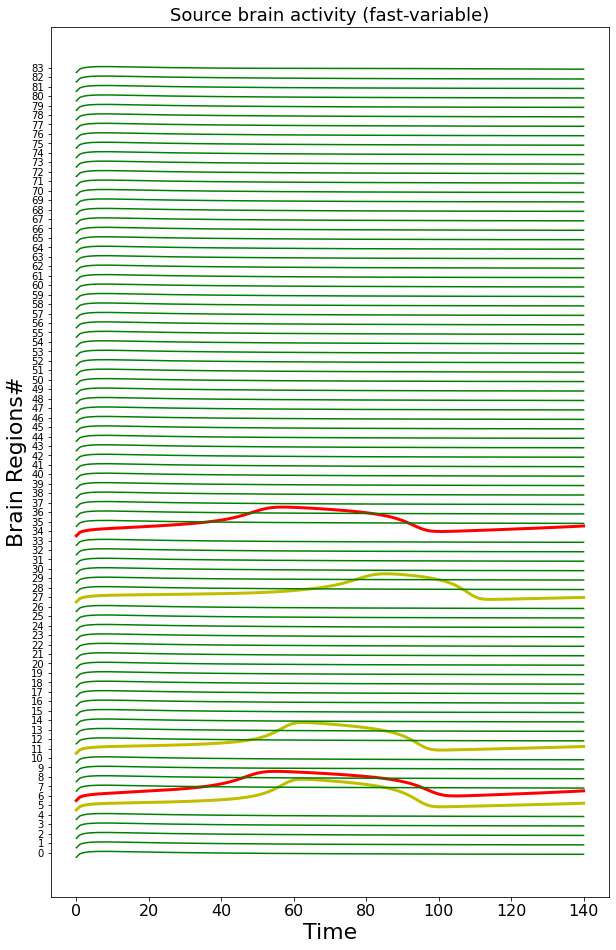

In [34]:
plt.figure(figsize=(10,16))
for i in range(0, nn):
    if i in ez_idx:
          plt.plot(X_true[i,:]+i, 'r', lw=3)
    elif i in pz_idx:
          plt.plot(X_true[i,:]+i, 'y', lw=3)
    else:  
          plt.plot(X_true[i,:]+i, 'g')
plt.yticks(np.r_[0:nn]-2, np.r_[0:nn],fontsize=10)
plt.xticks(fontsize=16)
plt.title("Source brain activity (fast-variable)",fontsize=18)
plt.xlabel('Time',fontsize=22)
plt.ylabel('Brain Regions#',fontsize=22)
plt.show()

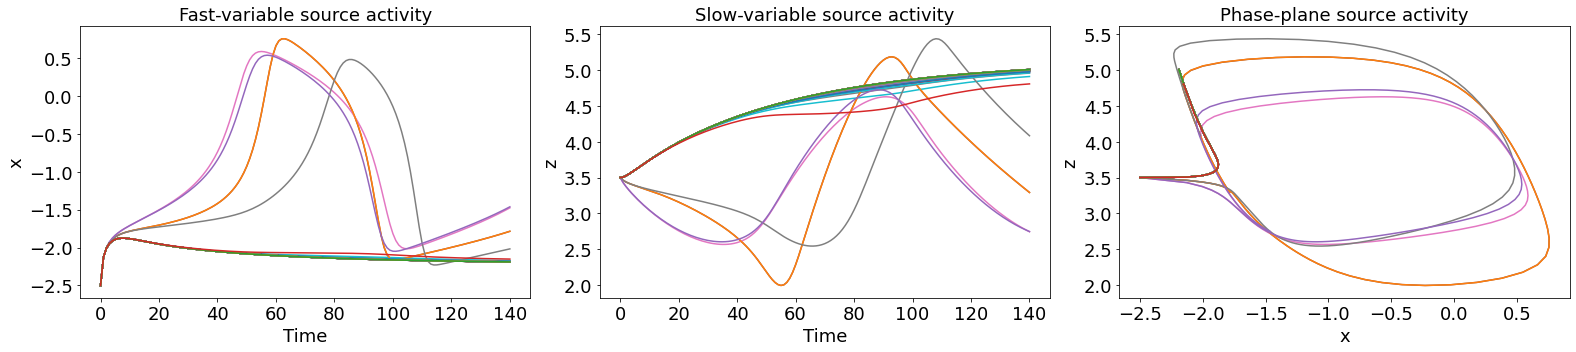

In [35]:
plt.figure(figsize=(22,5))
plt.subplot(131)
plt.plot(X_true.T);
plt.xlabel('Time',fontsize=18)
plt.ylabel('x',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("Fast-variable source activity",fontsize=18)

plt.subplot(132)
plt.plot(Z_true.T);
plt.xlabel('Time',fontsize=18)
plt.ylabel('z',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("Slow-variable source activity",fontsize=18)


plt.subplot(133)
plt.plot(X_true.T, Z_true.T);
plt.xlabel('x',fontsize=18)
plt.ylabel('z',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("Phase-plane source activity",fontsize=18)

plt.tight_layout()
plt.show()

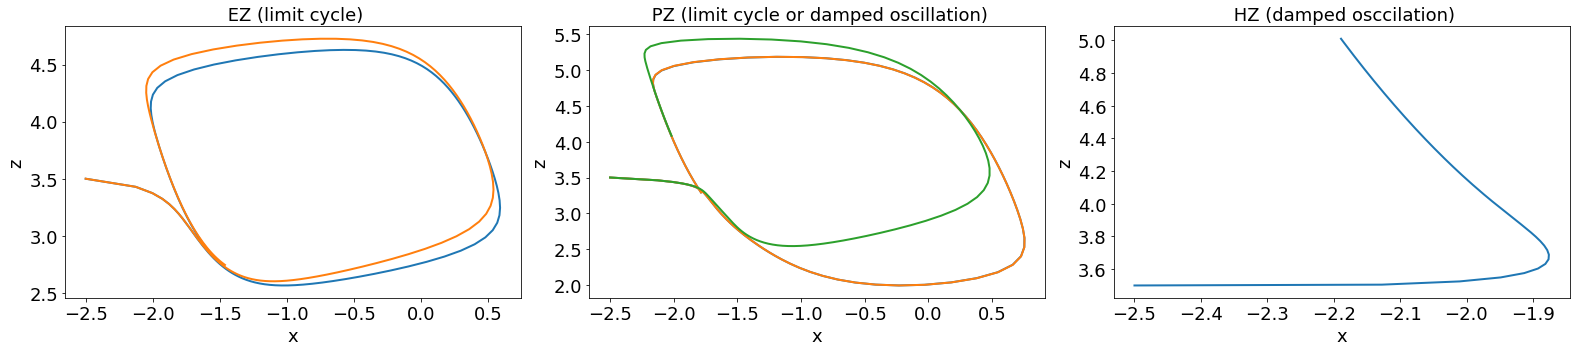

In [36]:
plt.figure(figsize=(22,5))
plt.subplot(131)
plt.plot(X_true[ez_idx].T, Z_true[ez_idx].T, lw=2);
plt.xlabel('x',fontsize=18)
plt.ylabel('z',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title(" EZ (limit cycle)",fontsize=18)

plt.subplot(132)
plt.plot(X_true[pz_idx].T, Z_true[pz_idx].T, lw=2);
plt.xlabel('x',fontsize=18)
plt.ylabel('z',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title(" PZ (limit cycle or damped oscillation)",fontsize=18)


plt.subplot(133)
plt.plot(X_true[1].T, Z_true[1].T, lw=2);
plt.xlabel('x',fontsize=18)
plt.ylabel('z',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title(" HZ (damped osccilation)",fontsize=18)

plt.tight_layout()
plt.show()

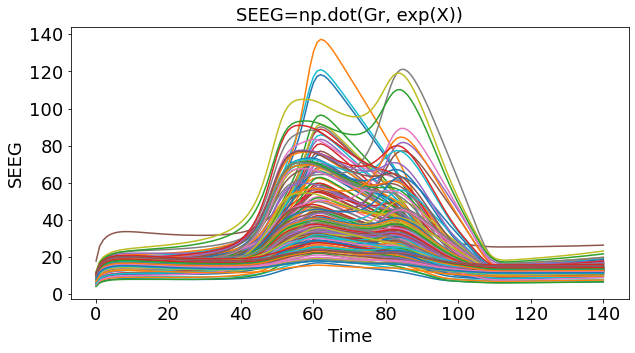

In [37]:
plt.figure(figsize=(10,5))
plt.plot(Seeg_true.T);
plt.xlabel('Time',fontsize=18)
plt.ylabel('SEEG',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("SEEG=np.dot(Gr, exp(X))",fontsize=18)
plt.show()

# Objective function

In [38]:
Seeg_true.shape

(162, 141)

In [39]:
Seeg_obs=Seeg_true

In [40]:
params_true=np.append(eta_true, K_true)
params_true

array([-3.5, -3.5, -3.5, -3.5, -3.5, -2.4, -1.6, -3.5, -3.5, -3.5, -3.5,
       -2.4, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -2.4, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -1.6, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,  1. ])

In [41]:
def RMSE(x1, x2):
    return np.sqrt(((x1 - x2) ** 2).mean()) 

### Optimizing only EZ/PZ/K

In [42]:
def black_box_function(x):
    eta_propsal=eta_true
    eta_propsal[ez_idx[0]]=x[0]
    eta_propsal[ez_idx[1]]=x[1]
    eta_propsal[pz_idx[0]]=x[2]
    eta_propsal[pz_idx[1]]=x[3]
    eta_propsal[pz_idx[2]]=x[4]
    K_propsal=x[5]
    
    params_val=np.append(eta_propsal, K_propsal)
    Sim =VEP2Dmodel_sensor(params_val, constants, init_conditions, SC, Gain, dt, ts)
    Seeg_model=Sim[0:(ns*nt)].reshape(ns, nt)

    return np.sqrt(np.sum((Seeg_model-Seeg_obs)**2))

### DE

In [43]:
bounds=[(-4, 0), (-4, 0), (-4, 0), (-4, 0), (-4, 0), (0, 2)]

In [44]:
from scipy.optimize import differential_evolution

In [45]:
val=[]
cost_val=[]
def callback(xk, convergence):
        val.append(convergence)
        cost_val.append(black_box_function(xk))
        #print(xk, convergence, cost_val)

In [46]:
%%time
result = differential_evolution(black_box_function, bounds,  popsize=10,  maxiter=100, disp=False,  callback=callback )

CPU times: user 7min 43s, sys: 6min 51s, total: 14min 35s
Wall time: 56.3 s


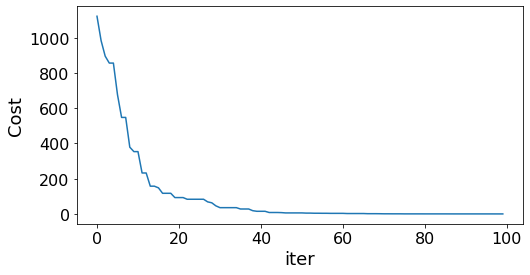

In [47]:
plt.figure(figsize=(8,4))
plt.plot(cost_val)
plt.ylabel('Cost', fontsize=18); 
plt.xlabel('iter', fontsize=18); 
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [48]:
result.x, result.fun

(array([-1.6       , -1.60000001, -2.39999996, -2.39999998, -2.40000001,
         1.00000002]),
 2.6735388508891213e-05)

In [49]:
idx_=[ez_idx[0], ez_idx[1], pz_idx[0], pz_idx[1], pz_idx[2], nn]
idx_

[6, 34, 5, 11, 27, 84]

In [50]:
params_est=np.zeros(nn+1)
params_est[0:nn+1]=params_true
params_est[idx_]=result.x

RMSE(params_est, params_true)

5.37437183609178e-09

In [51]:
Sim_est = VEP2Dmodel_sensor(params_est, constants, init_conditions, SC, Gain, dt, ts)

X_est=Sim_est[(ns*nt):(ns*nt)+(nn*nt)].reshape(nn, nt)
Z_est=Sim_est[(ns*nt)+(nn*nt):(ns*nt)+(2*nn*nt)].reshape(nn, nt)

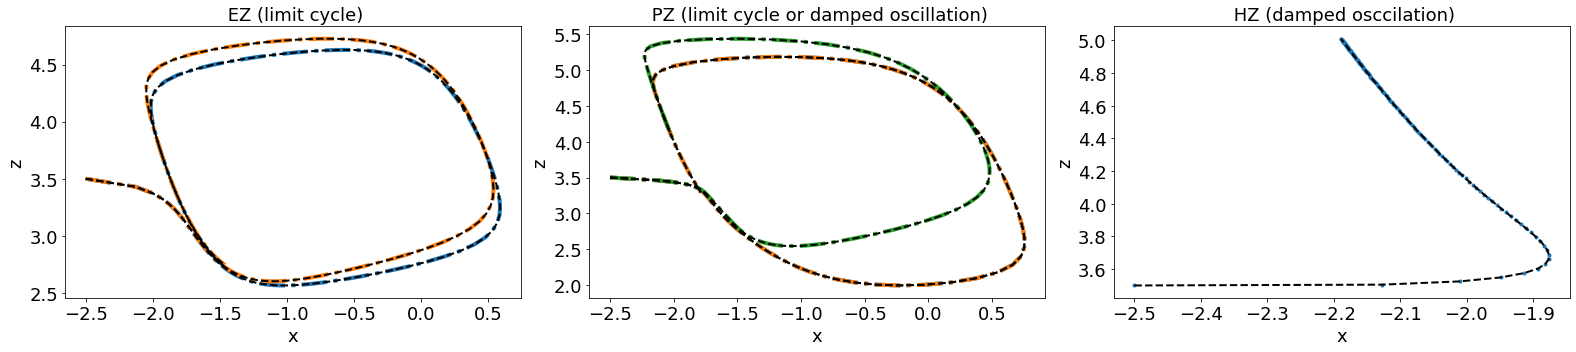

In [52]:
plt.figure(figsize=(22,5))
plt.subplot(131)
plt.plot(X_true[ez_idx].T, Z_true[ez_idx].T, '-.', lw=4);
plt.plot(X_est[ez_idx].T, Z_est[ez_idx].T, lw=2, color='k', linestyle='dashed');

plt.xlabel('x',fontsize=18)
plt.ylabel('z',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title(" EZ (limit cycle)",fontsize=18)

plt.subplot(132)
plt.plot(X_true[pz_idx].T, Z_true[pz_idx].T, '-.', lw=4);
plt.plot(X_est[pz_idx].T, Z_est[pz_idx].T, lw=2, color='k', linestyle='dashed');

plt.xlabel('x',fontsize=18)
plt.ylabel('z',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title(" PZ (limit cycle or damped oscillation)",fontsize=18)


plt.subplot(133)
plt.plot(X_true[1].T, Z_true[1].T, '.', lw=4);
plt.plot(X_est[1].T, Z_est[1].T, lw=2, color='k',linestyle='dashed');

plt.xlabel('x',fontsize=18)
plt.ylabel('z',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title(" HZ (damped osccilation)",fontsize=18)

plt.tight_layout()
plt.savefig("FittedVEP_limitcycle_EZPZ_DE.png", dpi=800)
plt.savefig("FittedVEP_limitcycle_EZPZ_DE.eps", dpi=800)
plt.show()

### PSO

In [53]:
from pyswarm import pso

In [54]:
lb = [-4, -4, -4, -4, -4, 0]
ub = [0, 0, 0, 0, 0, 2]

In [55]:
%%time

xopt, fopt = pso(black_box_function, lb, ub, swarmsize=100, maxiter=1000)

Stopping search: Swarm best position change less than 1e-08
CPU times: user 19min 53s, sys: 17min 23s, total: 37min 16s
Wall time: 2min 22s


In [56]:
xopt, fopt

(array([-1.59913841, -1.59390534, -2.53246179, -2.4910324 , -2.45123974,
         1.08075211]),
 62.28929691911697)

### PSO

In [57]:
import pyswarms as ps
from pyswarms.single.global_best import GlobalBestPSO

In [58]:
n_particles=10

In [59]:
def black_box_function_pso(x):
    eta_propsal=(eta_true.reshape(1,-1))*ones((n_particles,1))

    eta_propsal[:,ez_idx[0]]=x[:, 0]
    eta_propsal[:,ez_idx[1]]=x[:, 1]
    eta_propsal[:,pz_idx[0]]=x[:, 2]
    eta_propsal[:,pz_idx[1]]=x[:, 3]
    eta_propsal[:,pz_idx[2]]=x[:, 4]
    K_propsal=x[:, 5].reshape(-1,1)
    params_val=np.zeros((n_particles,nn+1))
    params_val= np.hstack([eta_propsal, K_propsal])
    Sim=zeros((n_particles, (ns*nt)+(2*nn*nt)))
    RMSE=zeros((n_particles))
    for i in range(n_particles):
        Sim[i,0:(ns*nt)+(2*nn*nt)] =VEP2Dmodel_sensor(params_val[i,0:nn+1], constants, init_conditions, SC, Gain, dt, ts)
        Seeg_model=Sim[i, 0:(ns*nt)].reshape(ns, nt)
        RMSE[i]=np.sqrt(np.sum((Seeg_model-Seeg_obs)**2))
    return RMSE

In [60]:
x_min = array([-4, -4, -4, -4, -4, 0])
x_max = array([0, 0, 0, 0, 0, 2])
bounds = (x_min, x_max)

In [61]:
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=6, options=options, bounds=bounds)

In [62]:
%%time

cost, pos = optimizer.optimize(black_box_function_pso, iters=500)

2023-01-27 18:42:13,460 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|500/500, best_cost=0.000273
2023-01-27 18:43:04,510 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.00027340626395627146, best pos: [-1.6        -1.59999987 -2.40000064 -2.40000075 -2.4         0.99999991]


CPU times: user 6min 50s, sys: 6min 16s, total: 13min 6s
Wall time: 51.1 s


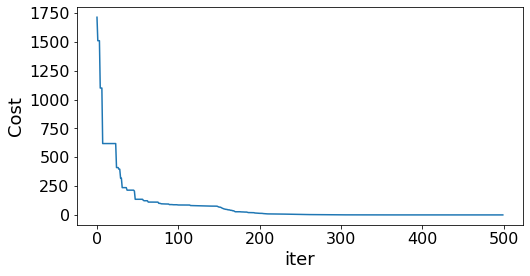

In [63]:
plt.figure(figsize=(8,4))
plt.plot(optimizer.cost_history)
plt.ylabel('Cost', fontsize=18); 
plt.xlabel('iter', fontsize=18); 
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

### Bayesian Optimization

In [64]:
from matplotlib import gridspec
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

def posterior(optimizer, x_obs, y_obs, grid):
    optimizer._gp.fit(x_obs, y_obs)

    mu, sigma = optimizer._gp.predict(grid, return_std=True)
    return mu, sigma

def plot_gp(optimizer, x, y):
    fig = plt.figure(figsize=(16, 10))
    steps = len(optimizer.space)
    fig.suptitle(
        'Gaussian Process and Utility Function After {} Steps'.format(steps),
        fontdict={'size':30}
    )
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])
    
    x_obs = np.array([[res["params"]["x"]] for res in optimizer.res])
    y_obs = np.array([res["target"] for res in optimizer.res])
    
    mu, sigma = posterior(optimizer, x_obs, y_obs, x)
    axis.plot(x, y, linewidth=3, label='Target')
    axis.plot(x_obs.flatten(), y_obs, 'D', markersize=8, label=u'Observations', color='r')
    axis.plot(x, mu, '--', color='k', label='Prediction')

    axis.fill(np.concatenate([x, x[::-1]]), 
              np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
        alpha=.6, fc='c', ec='None', label='95% confidence interval')
    
    axis.set_xlim((0, 2))
    axis.set_ylim((None, None))
    axis.set_ylabel('f(x)', fontdict={'size':20})
    axis.set_xlabel('x', fontdict={'size':20})
    
    utility_function = UtilityFunction(kind="ucb", kappa=5, xi=0)
    utility = utility_function.utility(x, optimizer._gp, 0)
    acq.plot(x, utility, label='Utility Function', color='purple')
    acq.plot(x[np.argmax(utility)], np.max(utility), '*', markersize=15, 
             label=u'Next Best Guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)
    acq.set_xlim((0, 2))
    acq.set_ylim((-25, np.max(utility) + 1.5))
    acq.set_ylabel('Utility', fontdict={'size':20})
    acq.set_xlabel('x', fontdict={'size':20})
    
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

In [65]:
def black_box_function_BO(eta_ez1, eta_ez2, eta_pz1, eta_pz2, eta_pz3, K):
    
    eta_propsal=eta_true
    eta_propsal[ez_idx[0]]=eta_ez1
    eta_propsal[ez_idx[1]]=eta_ez2
    eta_propsal[pz_idx[0]]=eta_pz1
    eta_propsal[pz_idx[1]]=eta_pz2
    eta_propsal[pz_idx[2]]=eta_pz3

    K_propsal=K
    
    params_val=np.append(eta_propsal, K_propsal)
    Sim =VEP2Dmodel_sensor(params_val, constants, init_conditions, SC, Gain, dt, ts)
    Seeg_model=Sim[0:(ns*nt)].reshape(ns, nt)

    return -1*np.sqrt(np.sum((Seeg_model-Seeg_obs)**2))

In [66]:
pbounds = {'eta_ez1': (-4, 0) , 'eta_ez2': (-4, 0) , 'eta_pz1': (-4, 0) , 'eta_pz2': (-4, 0) , 'eta_pz3': (-4, 0) , 'K': (0, 2)}
pbounds

{'eta_ez1': (-4, 0),
 'eta_ez2': (-4, 0),
 'eta_pz1': (-4, 0),
 'eta_pz2': (-4, 0),
 'eta_pz3': (-4, 0),
 'K': (0, 2)}

In [67]:
from bayes_opt import BayesianOptimization
optimizer = BayesianOptimization(
    f=black_box_function_BO,
    pbounds=pbounds,
    random_state=1,
)

In [68]:
%%time

optimizer.maximize(init_points=50,n_iter=50, kappa=100)


|   iter    |  target   |     K     |  eta_ez1  |  eta_ez2  |  eta_pz1  |  eta_pz2  |  eta_pz3  |
-------------------------------------------------------------------------------------------------
| 1         | -1.893e+0 | 0.834     | -1.119    | -4.0      | -2.791    | -3.413    | -3.631    |
| 2         | -2.264e+0 | 0.3725    | -2.618    | -2.413    | -1.845    | -2.323    | -1.259    |
| 3         | -2.59e+03 | 0.4089    | -0.4875   | -3.89     | -1.318    | -2.331    | -1.765    |
| 4         | -2.29e+03 | 0.2808    | -3.208    | -0.797    | -0.127    | -2.746    | -1.231    |
| 5         | -3.497e+0 | 1.753     | -0.4216   | -3.66     | -3.844    | -3.321    | -0.4874   |
| 6         | -2.255e+0 | 0.1967    | -2.316    | -0.1684   | -1.867    | -1.232    | -2.738    |
| 7         | -3.264e+0 | 1.373     | -0.6615   | -3.927    | -0.9994   | -0.04456  | -1.007    |
| 8         | -2.081e+0 | 0.5609    | -0.8429   | -3.587    | -2.208    | -0.3656   | -2.826    |
| 9         | -2.842

| 51        | -1.797e+0 | 1.18      | -1.773    | -2.118    | -2.157    | -4.0      | -3.039    |
| 52        | -2.168e+0 | 1.134     | -2.221    | -1.392    | -3.694    | -4.0      | -2.636    |
| 53        | -1.691e+0 | 1.892     | -1.482    | -2.736    | -0.7508   | -2.537    | -3.592    |
| 54        | -1.706e+0 | 2.0       | -1.508    | -2.914    | -2.881    | -2.638    | -2.959    |
| 55        | -1.909e+0 | 2.0       | -1.103    | -0.8566   | -2.437    | -3.193    | -3.173    |
| 56        | -1.715e+0 | 0.5187    | -1.237    | -3.529    | 0.0       | -2.915    | -4.0      |
| 57        | -3.518e+0 | 0.09201   | -3.758    | -0.5381   | -2.173    | -0.3607   | 0.0       |
| 58        | -2.708e+0 | 1.307     | -2.203    | -4.0      | -2.177    | -1.507    | -2.38     |
| 59        | -1.884e+0 | 2.0       | -1.018    | -3.653    | -1.411    | -3.911    | -2.597    |
| 60        | -2.034e+0 | 1.086     | -1.83     | -2.559    | 0.0       | -3.243    | -2.846    |
| 61        | -1.624

In [69]:
optimizer.maximize(init_points=50,n_iter=50, xi=0.1)

|   iter    |  target   |     K     |  eta_ez1  |  eta_ez2  |  eta_pz1  |  eta_pz2  |  eta_pz3  |
-------------------------------------------------------------------------------------------------
| 101       | -2.756e+0 | 1.624     | -0.5002   | -1.246    | -1.722    | -3.356    | -2.132    |
| 102       | -2.028e+0 | 0.6903    | -3.1      | -1.63     | -2.751    | -0.3348   | -0.3615   |
| 103       | -2.771e+0 | 0.5142    | -3.556    | -3.228    | -2.002    | -1.086    | -3.167    |
| 104       | -2.393e+0 | 0.4961    | -0.5933   | -2.337    | -1.533    | -3.065    | -3.592    |
| 105       | -2.365e+0 | 1.032     | -2.091    | -3.389    | -1.513    | -1.824    | -1.383    |
| 106       | -1.762e+0 | 0.2891    | -0.9939   | -3.112    | -1.923    | -0.8588   | -3.911    |
| 107       | -5.334e+0 | 0.6487    | -0.5083   | -0.6212   | -1.846    | -0.5336   | -0.2008   |
| 108       | -2.81e+03 | 1.653     | -0.5835   | -3.605    | -1.395    | -1.186    | -1.559    |
| 109       | -2.31e

| 151       | -749.3    | 1.422     | -1.631    | -1.333    | -3.038    | -3.143    | -2.443    |
| 152       | -1.634e+0 | 1.481     | -1.648    | -0.241    | -2.376    | -3.978    | -2.359    |
| 153       | -688.1    | 0.9581    | -1.594    | -1.31     | -3.189    | -1.152    | -2.391    |
| 154       | -995.3    | 1.054     | -1.609    | -1.436    | -3.623    | -0.7192   | -2.932    |
| 155       | -727.9    | 1.04      | -1.41     | -1.596    | -2.573    | -0.3703   | -2.565    |
| 156       | -594.9    | 0.6496    | -1.63     | -1.502    | -2.325    | -0.7962   | -2.245    |
| 157       | -2.82e+03 | 0.1513    | -3.669    | -3.651    | -3.737    | -0.06173  | -0.02232  |
| 158       | -1.605e+0 | 0.7845    | -1.967    | -1.624    | -1.517    | -0.8536   | -1.87     |
| 159       | -1.155e+0 | 0.03799   | -1.643    | -1.703    | -2.346    | -0.5011   | -2.79     |
| 160       | -877.5    | 0.8819    | -1.541    | -1.31     | -2.187    | -1.113    | -2.404    |
| 161       | -1.331

In [70]:
print(optimizer.max)

{'target': -546.2160535818101, 'params': {'K': 1.7144287119685262, 'eta_ez1': -1.4393379793474643, 'eta_ez2': -1.6593204137682036, 'eta_pz1': -3.5818632644582014, 'eta_pz2': -2.6173444392532343, 'eta_pz3': -2.7284834085977763}}


In [71]:
params_opt=optimizer.max['params']
params_opt

{'K': 1.7144287119685262,
 'eta_ez1': -1.4393379793474643,
 'eta_ez2': -1.6593204137682036,
 'eta_pz1': -3.5818632644582014,
 'eta_pz2': -2.6173444392532343,
 'eta_pz3': -2.7284834085977763}

In [72]:
params_est=np.zeros(nn+1)

params_est[0:nn+1]=params_true

params_est[ez_idx[0]]=params_opt['eta_ez1']
params_est[ez_idx[1]]=params_opt['eta_ez2']

params_est[pz_idx[0]]=params_opt['eta_pz1']
params_est[pz_idx[1]]=params_opt['eta_pz2']
params_est[pz_idx[2]]=params_opt['eta_pz3']

params_est[-1]=params_opt['K']

In [73]:
RMSE(params_est, params_true)

0.15686938409836035

In [74]:
Sim_est = VEP2Dmodel_sensor(params_est, constants, init_conditions, SC, Gain, dt, ts)

X_est=Sim_est[(ns*nt):(ns*nt)+(nn*nt)].reshape(nn, nt)
Z_est=Sim_est[(ns*nt)+(nn*nt):(ns*nt)+(2*nn*nt)].reshape(nn, nt)

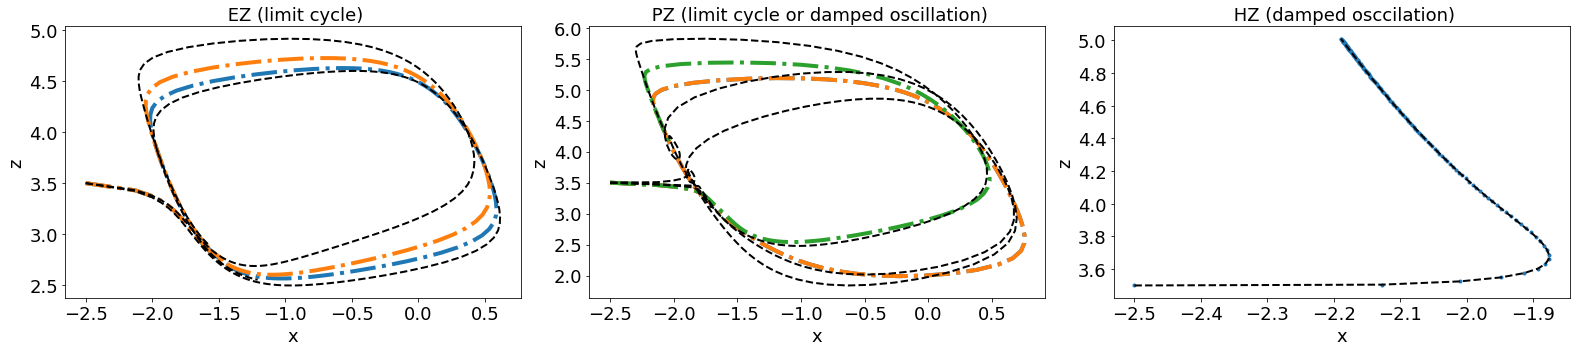

In [75]:
plt.figure(figsize=(22,5))
plt.subplot(131)
plt.plot(X_true[ez_idx].T, Z_true[ez_idx].T, '-.', lw=4);
plt.plot(X_est[ez_idx].T, Z_est[ez_idx].T, lw=2, color='k', linestyle='dashed');

plt.xlabel('x',fontsize=18)
plt.ylabel('z',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title(" EZ (limit cycle)",fontsize=18)

plt.subplot(132)
plt.plot(X_true[pz_idx].T, Z_true[pz_idx].T, '-.', lw=4);
plt.plot(X_est[pz_idx].T, Z_est[pz_idx].T, lw=2, color='k', linestyle='dashed');

plt.xlabel('x',fontsize=18)
plt.ylabel('z',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title(" PZ (limit cycle or damped oscillation)",fontsize=18)


plt.subplot(133)
plt.plot(X_true[1].T, Z_true[1].T, '.', lw=4);
plt.plot(X_est[1].T, Z_est[1].T, lw=2, color='k',linestyle='dashed');

plt.xlabel('x',fontsize=18)
plt.ylabel('z',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title(" HZ (damped osccilation)",fontsize=18)

plt.tight_layout()
plt.savefig("FittedVEP_limitcycle_EZPZ_Bayesopt.png", dpi=800)
plt.savefig("FittedVEP_limitcycle_EZPZ_Bayesopt.eps", dpi=800)
plt.show()

### Optimization on whole-brain parameters

In [76]:
def f(x):
    eta_propsal=x[0:nn]
    K_propsal=x[-1]
    params_val=np.append(eta_propsal, K_propsal)
    Sim =VEP2Dmodel_sensor(params_val, constants, init_conditions, SC, Gain, dt, ts)
    Seeg_model=Sim[0:(ns*nt)].reshape(ns, nt)

    return np.sqrt(np.sum((Seeg_model-Seeg_obs)**2))

### DE

In [77]:
bounds_= [(-4,0) for _ in range(nn)]
bounds_K=[(0,2)]
bounds_.extend(bounds_K)
bounds=bounds_

In [78]:
val=[]
cost_val=[]
def callback(xk, convergence):
        val.append(convergence)
        cost_val.append(f(xk))
        #print(xk, convergence, cost_val)

In [79]:
%%time

result = differential_evolution(f, bounds,  popsize=20,  maxiter=1000, disp=False,  callback=callback )

CPU times: user 1d 8h 16min 22s, sys: 1d 3h 59min 29s, total: 2d 12h 15min 52s
Wall time: 3h 49min 33s


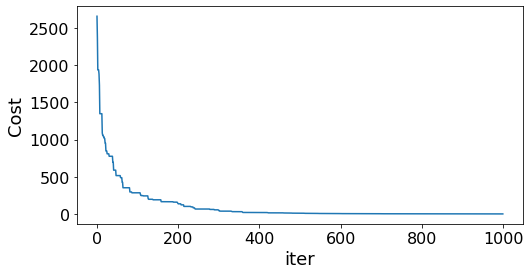

In [80]:
plt.figure(figsize=(8,4))
plt.plot(cost_val)
plt.ylabel('Cost', fontsize=18); 
plt.xlabel('iter', fontsize=18); 
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [81]:
result.x, result.fun

(array([-3.3621717 , -3.71604304, -3.93548358, -3.7347029 , -3.91161729,
        -2.39325896, -1.59980468, -3.51221245, -3.64986461, -3.49954863,
        -3.62368818, -2.39568305, -2.58392769, -3.49779438, -3.60888167,
        -3.7449685 , -3.14607948, -3.27937569, -3.81268446, -3.49123067,
        -3.35231038, -3.48636644, -3.88874269, -3.41923483, -3.20291901,
        -3.67977331, -3.17647744, -2.39810719, -3.60545059, -3.51649246,
        -3.03859911, -3.77247385, -3.27979365, -3.56464473, -1.59785568,
        -3.85282855, -3.85116952, -3.61457592, -3.72293166, -3.52663459,
        -3.37712046, -3.75452393, -3.06013488, -3.24584735, -2.99142918,
        -3.3163077 , -2.37211263, -3.72000431, -2.56270902, -3.33383505,
        -2.65825615, -3.52389248, -3.08898379, -3.1636982 , -3.69427631,
        -3.55147104, -3.24433261, -3.39889622, -3.64645383, -3.93934609,
        -3.58605813, -2.77119311, -3.4705664 , -3.5024761 , -3.50996095,
        -2.48512519, -2.77709943, -2.94058529, -3.1

In [82]:
params_est=np.zeros(nn+1)
params_est[0:nn+1]=result.x

RMSE(params_est, params_true)

0.3583549166750548

In [83]:
Sim_est = VEP2Dmodel_sensor(params_est, constants, init_conditions, SC, Gain, dt, ts)

X_est=Sim_est[(ns*nt):(ns*nt)+(nn*nt)].reshape(nn, nt)
Z_est=Sim_est[(ns*nt)+(nn*nt):(ns*nt)+(2*nn*nt)].reshape(nn, nt)

In [84]:
nodes=np.r_[0:nn]

2023-01-27 22:33:37,857 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2023-01-27 22:33:37,859 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2023-01-27 22:33:37,859 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2023-01-27 22:33:37,860 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2023-01-27 22:33:37,861 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2023-01-27 22:33:37,862 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support t

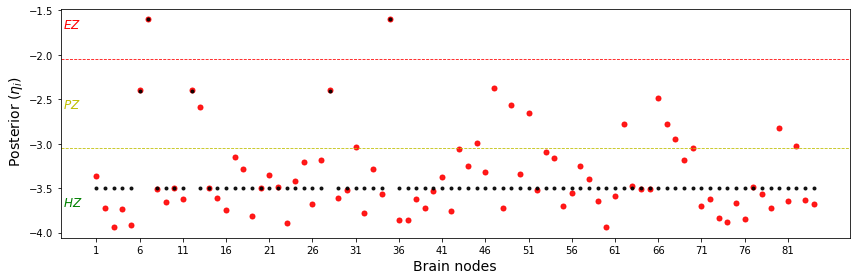

In [85]:
plt.figure(figsize=(12, 4))
plt.plot(nodes+1, params_est[0:nn] ,'o', color='r', alpha=0.9, markersize=5)

plt.plot(ez_idx+1, ez_val*np.ones((len(ez_idx))) ,'o', color='k', alpha=0.9, markersize=3)
plt.plot(pz_idx+1, pz_val*np.ones((len(pz_idx))) ,'o', color='k', alpha=0.9, markersize=3)
plt.plot(hz_idx+1, hz_val*np.ones((len(hz_idx))),'o' , color='k', alpha=0.9, markersize=3)
plt.axhline(y=eta_c, linewidth=.8, color = 'r', linestyle='--')
plt.axhline(y=eta_c-delta_eta, linewidth=.8, color = 'y', linestyle='--')
text(-2.85, -1.7, "$EZ$", size=12, color = 'r')
text(-2.85, -2.6, "$PZ$", size=12, color = 'y')
text(-2.85, -3.7, "$HZ$", size=12, color = 'g')
#plt.xticks(np.r_[1:len(nodes)+1], np.r_[1:len(nodes)+1], rotation=90, fontsize=8)  
plt.xticks(np.arange(1,len(nodes)+1, step=5),np.arange(1, len(nodes)+1, step=5), fontsize=10, rotation=0)
plt.ylabel(' Posterior ' +r'${(\eta_i)}$', fontsize=14);  
plt.xlabel('Brain nodes', fontsize=14); 
plt.tight_layout()

plt.savefig("FittedVEP_violonplot_DE.png", dpi=800)
plt.savefig("FittedVEP_violonplot_DE.eps", dpi=800)
plt.show()

### PSO

In [86]:
from pyswarm import pso

In [87]:
lb= [-4] * nn
lb.extend([0])

ub= [0] * nn
ub.extend([2])

In [88]:
%%time

xopt, fopt = pso(black_box_function, lb, ub, swarmsize=100, maxiter=1000)

Stopping search: Swarm best objective change less than 1e-08
CPU times: user 9min 57s, sys: 8min 38s, total: 18min 36s
Wall time: 1min 10s


In [89]:
xopt, fopt

(array([-1.64713139, -1.70487675, -2.06274696, -1.74500629, -1.94821718,
         0.        , -1.56507334, -1.15177557, -2.0995276 , -3.74989213,
        -0.81141513, -1.16966266, -0.50890479, -2.79506775, -1.14866533,
        -3.93294054, -2.78119074, -1.89611689, -1.11646997, -0.28413185,
        -1.5687178 , -2.66681382, -0.6107634 , -1.85689885, -2.21636152,
        -0.91279916, -1.45378343, -1.178966  , -1.00766283, -2.02835618,
        -0.9513154 , -1.11630281, -2.26251734, -0.26819694, -3.27066384,
        -3.59232806, -3.03761879, -2.47539449, -2.37493304, -0.71752081,
        -1.98642119, -0.51667674, -1.80979051, -1.73587528, -4.        ,
        -3.0894479 , -1.32216432, -0.65386383, -1.08069429, -2.14501377,
        -2.27348839, -2.04782485, -1.56819511, -1.82991326, -3.37359183,
        -1.83125205, -1.80027491, -1.79084736, -3.01947367, -2.52497955,
        -1.45656938, -2.17859829, -2.82843897, -3.57679513, -3.40024099,
        -1.61162984, -0.03835048, -2.56710948, -1.4

In [90]:
RMSE(xopt, params_true)

1.8573184333984194

### PSO

In [91]:
import pyswarms as ps
from pyswarms.single.global_best import GlobalBestPSO

In [92]:
n_particles=100

In [93]:
def black_box_function_pso(x):
    eta_propsal=(zeros(nn).reshape(1,-1))*ones((n_particles,1))
    eta_propsal[:,0:nn-1]=x[:, 0:nn-1]
    K_propsal=x[:, nn].reshape(-1,1)
    
    params_val=np.zeros((n_particles,nn+1))
    params_val= np.hstack([eta_propsal, K_propsal])
    Sim=zeros((n_particles,(ns*nt)+(2*nn*nt)))
    RMSE=zeros((n_particles))
    for i in range(n_particles):
        Sim[i,0:(ns*nt)+(2*nn*nt)] =VEP2Dmodel_sensor(params_val[i,0:nn+1], constants, init_conditions, SC, Gain, dt, ts)
        Seeg_model=Sim[i, 0:(ns*nt)].reshape(ns, nt)
        RMSE[i]=np.sqrt(np.sum((Seeg_model-Seeg_obs)**2))
    return RMSE

In [94]:
x_min = np.repeat(-4, nn)
x_max =np.repeat(0, nn)

bounds = (np.append(x_min,  0) , np.append(x_max,  2))

In [95]:
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=nn+1, options=options, bounds=bounds)

In [96]:
%%time

cost, pos = optimizer.optimize(black_box_function_pso, iters=1000)

2023-01-27 22:34:49,050 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=1.38e+3
2023-01-27 22:48:28,752 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1383.0289115880685, best pos: [-2.4956578  -2.98904745 -2.50350633 -2.00324542 -2.75068563 -3.03659867
 -1.64544367 -3.13374649 -2.41564103 -2.46898085 -1.8751214  -1.57313055
 -2.30675606 -3.98025397 -2.28415326 -2.43908173 -2.96001736 -2.42140361
 -2.4641025  -2.43719356 -2.76536291 -2.66596342 -2.22397663 -3.24055597
 -2.85807388 -1.49359109 -3.43501018 -2.16301926 -2.8524587  -2.57785099
 -2.13478462 -2.97202643 -3.04182706 -3.62239238 -3.48625761 -2.36418893
 -1.7706631  -1.54653102 -1.71308426 -2.5838838  -3.14238329 -2.74198565
 -2.30345638 -1.4932176  -2.82537249 -2.24914862 -2.74498134 -2.51826658
 -2.6981428  -3.26269752 -1.66430409 -2.03184947 -3.99890068 -2.35788349
 -1.74814978 -3.

CPU times: user 1h 54min 10s, sys: 1h 40min 21s, total: 3h 34min 31s
Wall time: 13min 39s


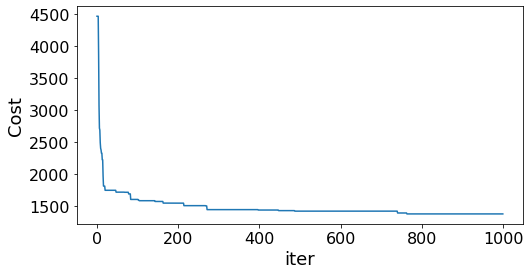

In [97]:
plt.figure(figsize=(8,4))
plt.plot(optimizer.cost_history)
plt.ylabel('Cost', fontsize=18); 
plt.xlabel('iter', fontsize=18); 
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

### Bayesian Optimization

In [98]:
bounds_eta = np.array([[-4*ones(nn), .0*ones(nn)]]).T[:,:,0]
bounds_K = np.array([[0, 2]])
bounds_eta.shape, bounds_K.shape

((84, 2), (1, 2))

In [99]:
bounds=np.vstack([bounds_eta, bounds_K])
bounds.shape

(85, 2)

In [100]:
from skopt import gp_minimize

res = gp_minimize(f,                  # the function to minimize
                  bounds,      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=1000,         # the number of evaluations of f
                  n_random_starts=1000,  # the number of random initialization points
                  noise=0.0,       # the noise level (optional)
                  random_state=1234)   # the random seed


In [101]:
params_est=res.x

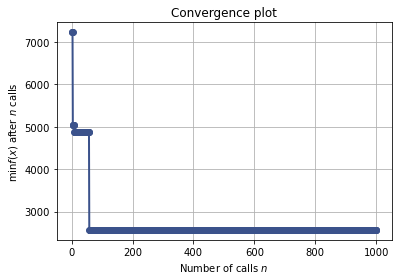

In [102]:
from skopt.plots import plot_convergence
plot_convergence(res);

In [103]:
Sim_est = VEP2Dmodel_sensor(params_est, constants, init_conditions, SC, Gain, dt, ts)

X_est=Sim_est[(ns*nt):(ns*nt)+(nn*nt)].reshape(nn, nt)
Z_est=Sim_est[(ns*nt)+(nn*nt):(ns*nt)+(2*nn*nt)].reshape(nn, nt)

In [104]:
RMSE(np.asarray(params_est), np.asarray(params_true))

1.7774859726517052

In [105]:
nodes=np.r_[0:nn]

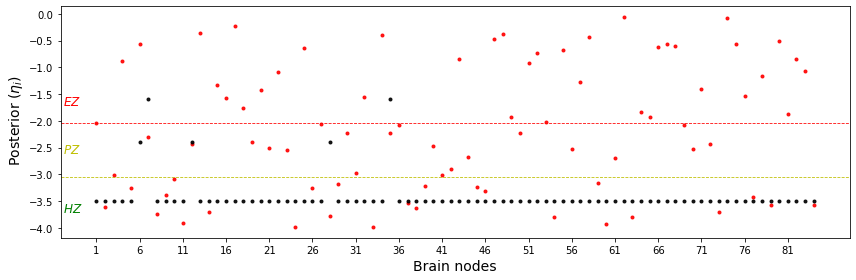

In [106]:
plt.figure(figsize=(12, 4))
plt.plot(nodes+1, params_est[0:nn] ,'o', color='r', alpha=0.9, markersize=3)

plt.plot(ez_idx+1, ez_val*np.ones((len(ez_idx))) ,'o', color='k', alpha=0.9, markersize=3)
plt.plot(pz_idx+1, pz_val*np.ones((len(pz_idx))) ,'o', color='k', alpha=0.9, markersize=3)
plt.plot(hz_idx+1, hz_val*np.ones((len(hz_idx))),'o' , color='k', alpha=0.9, markersize=3)
plt.axhline(y=eta_c, linewidth=.8, color = 'r', linestyle='--')
plt.axhline(y=eta_c-delta_eta, linewidth=.8, color = 'y', linestyle='--')
text(-2.85, -1.7, "$EZ$", size=12, color = 'r')
text(-2.85, -2.6, "$PZ$", size=12, color = 'y')
text(-2.85, -3.7, "$HZ$", size=12, color = 'g')
#plt.xticks(np.r_[1:len(nodes)+1], np.r_[1:len(nodes)+1], rotation=90, fontsize=8)  
plt.xticks(np.arange(1,len(nodes)+1, step=5),np.arange(1, len(nodes)+1, step=5), fontsize=10, rotation=0)
plt.ylabel(' Posterior ' +r'${(\eta_i)}$', fontsize=14);  
plt.xlabel('Brain nodes', fontsize=14); 
plt.tight_layout()

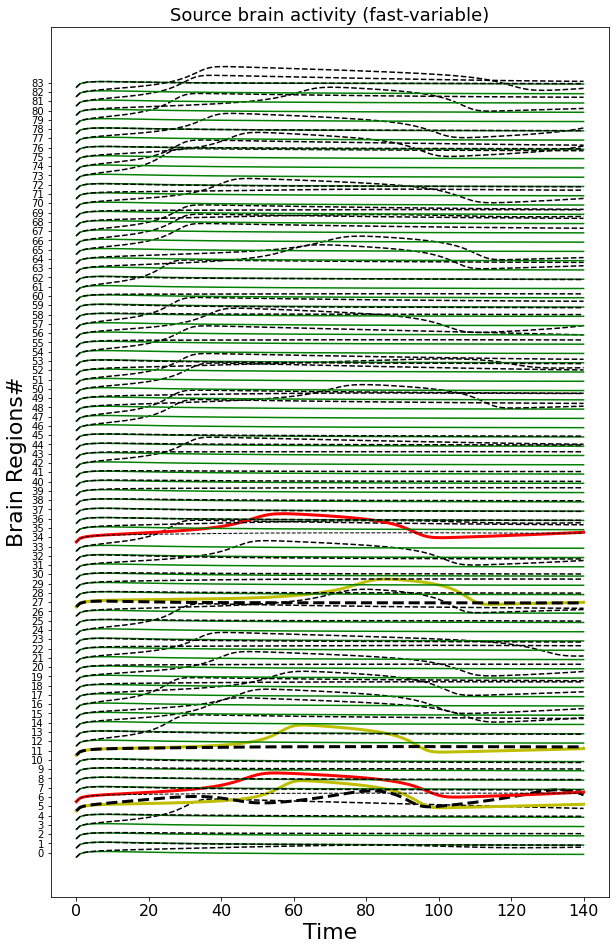

In [107]:
plt.figure(figsize=(10,16))
for i in range(0, nn):
    if i in ez_idx:
          plt.plot(X_true[i,:]+i, 'r', lw=3)
          plt.plot(X_est[i,:]+i, 'k--', lw=1)
    elif i in pz_idx:
          plt.plot(X_true[i,:]+i, 'y', lw=3)
          plt.plot(X_est[i,:]+i, 'k--', lw=3)
    else:  
          plt.plot(X_true[i,:]+i, 'g')
          plt.plot(X_est[i,:]+i, 'k--')
plt.yticks(np.r_[0:nn]-2, np.r_[0:nn],fontsize=10)
plt.xticks(fontsize=16)
plt.title("Source brain activity (fast-variable)",fontsize=18)
plt.xlabel('Time',fontsize=22)
plt.ylabel('Brain Regions#',fontsize=22)

plt.savefig("FittedVEP_Bayesopt.png", dpi=800)
plt.savefig("FittedVEP_Bayesopt.eps", dpi=800)

plt.show()

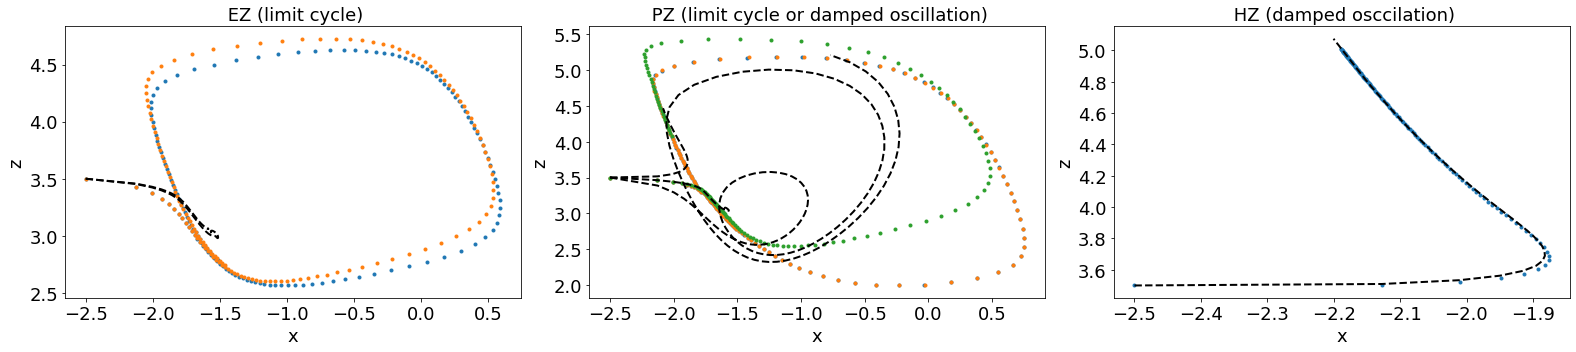

In [108]:
plt.figure(figsize=(22,5))
plt.subplot(131)
plt.plot(X_true[ez_idx].T, Z_true[ez_idx].T, '.', lw=4);
plt.plot(X_est[ez_idx].T, Z_est[ez_idx].T, lw=2, color='k', linestyle='dashed');

plt.xlabel('x',fontsize=18)
plt.ylabel('z',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title(" EZ (limit cycle)",fontsize=18)

plt.subplot(132)
plt.plot(X_true[pz_idx].T, Z_true[pz_idx].T, '.', lw=4);
plt.plot(X_est[pz_idx].T, Z_est[pz_idx].T, lw=2, color='k', linestyle='dashed');

plt.xlabel('x',fontsize=18)
plt.ylabel('z',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title(" PZ (limit cycle or damped oscillation)",fontsize=18)


plt.subplot(133)
plt.plot(X_true[1].T, Z_true[1].T, '.', lw=4);
plt.plot(X_est[1].T, Z_est[1].T, lw=2, color='k',linestyle='dashed');

plt.xlabel('x',fontsize=18)
plt.ylabel('z',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title(" HZ (damped osccilation)",fontsize=18)

plt.tight_layout()
plt.savefig("FittedVEP_limitcycle_Bayesopt.png", dpi=800)
plt.savefig("FittedVEP_limitcycle_Bayesopt.eps", dpi=800)
plt.show()